In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Capture passenger honorifics

In [5]:
#regex pattern to capture the title in the name field
pattern = r'\s(\w+)\.{1,1}\s'
train['Title'] = train['Name'].str.extract(pattern)

In [6]:
#repeating this for test
pattern = r'\s(\w+)\.{1,1}\s'
test['Title'] = test['Name'].str.extract(pattern)

### Capture ticket types

In [7]:
#extracting ticket type
ticket_letters = train['Ticket'].str.split(' ')
letters = [x[0] if not x[0].isdigit() else 'X' for x in ticket_letters]
train['TicketCat'] = letters

In [8]:
#same for test
ticket_letters = test['Ticket'].str.split(' ')
letters = [x[0] if not x[0].isdigit() else 'X' for x in ticket_letters]
test['TicketCat'] = letters

### Average ticket type per class

/tmp/ipykernel_20/1706698076.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_fare_pclass = train.groupby(by='Pclass', as_index=False).mean()


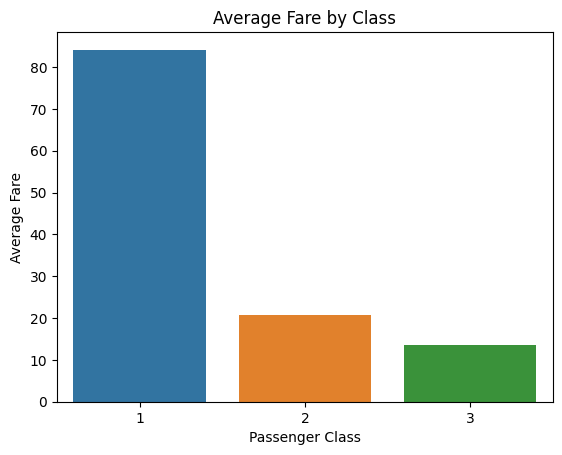

In [9]:
avg_fare_pclass = train.groupby(by='Pclass', as_index=False).mean()
sns.barplot(avg_fare_pclass, x='Pclass', y='Fare')
plt.xlabel('Passenger Class')
plt.ylabel('Average Fare')
plt.title('Average Fare by Class')
plt.show()

### Unique 1st class cabins

In [10]:
# can use .loc for shorter syntax: train.loc[train['Pclass']==1, 'Cabin'].value_counts()
train[train['Pclass']==1]['Cabin'].value_counts()

B96 B98        4
C23 C25 C27    4
C22 C26        3
E24            2
E67            2
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 133, dtype: int64

In [11]:
train.loc[train.Fare > np.mean(train.Fare), 'Pclass'].value_counts()

1    159
3     30
2     22
Name: Pclass, dtype: int64

In [12]:
train.groupby(by='Pclass Sex'.split())[['Survived']].value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
dtype: int64

Currently its apparent from my observations that the best odds of survival are for women, especially in 1st class. Sex and passenger class appear to be the most determining factors in survival. 

For men, being in the 1st class is the best of odds survival (45/122 survived).

### Display the age of passengers with highest survival rate

Text(0.5, 1.0, 'Survived by Gender')

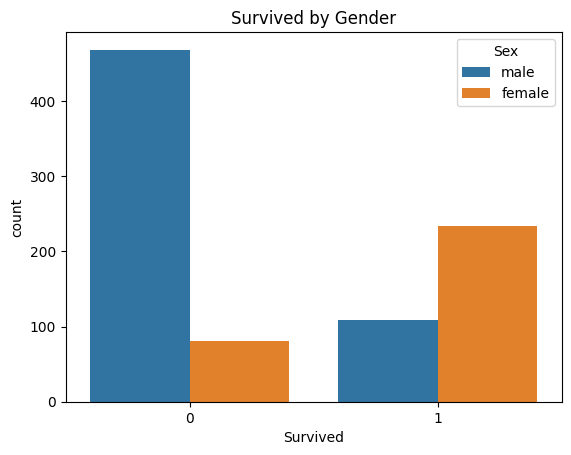

In [13]:
sns.countplot(x='Survived', hue='Sex', data=train)
plt.title('Survived by Gender')

### Handle missing cabins

In [14]:
train.Cabin.fillna(0, inplace=True)
test.Cabin.fillna(0, inplace=True)

In [15]:
test.Fare.fillna(0,inplace=True)

In [16]:
#Feature engineering creating a column called HasCabin
train['HasCabin'] = np.select([train['Cabin'] != 0, train['Cabin'] == 0], [1, 0])

In [17]:
#Feature engineering creating a column called HasCabin
test['HasCabin'] = np.select([test['Cabin'] != 0, test['Cabin'] == 0], [1, 0])

<AxesSubplot: xlabel='HasCabin', ylabel='count'>

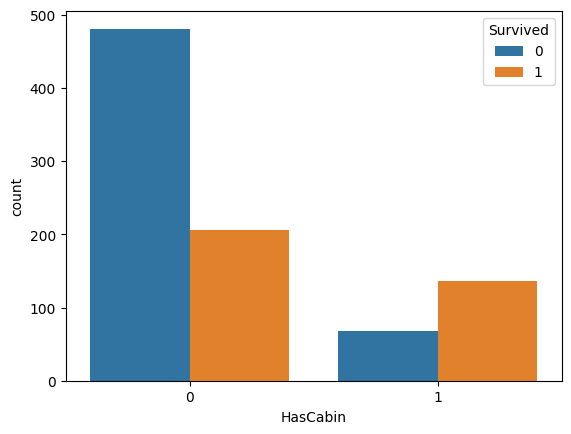

In [18]:
survived_cabin = train.groupby(by='HasCabin', as_index=False)[['Survived']].value_counts()
sns.barplot(survived_cabin, x='HasCabin', y='count', hue='Survived')

The survival rate of people with cabins is ~67% while those without is ~30%. Hence, having a cabin also increases once chances of survival (most likely wealthier passengers with a higher class). 

Outcome: most people with cabins have survived.

In [19]:
mean_class3 = train[train.Pclass == 3]['Age'].mean()
mean_class2 = train[train.Pclass == 2]['Age'].mean()
mean_class1 = train[train.Pclass == 1]['Age'].mean()

train.loc[(train.Pclass == 3) & (train.Age.isna()), 'Age'] = mean_class3
train.loc[(train.Pclass == 2) & (train.Age.isna()), 'Age'] = mean_class2
train.loc[(train.Pclass == 1) & (train.Age.isna()), 'Age'] = mean_class1

mean_class3 = test[test.Pclass == 3]['Age'].mean()
mean_class2 = test[test.Pclass == 2]['Age'].mean()
mean_class1 = test[test.Pclass == 1]['Age'].mean()

test.loc[(test.Pclass == 3) & (test.Age.isna()), 'Age'] = mean_class3
test.loc[(test.Pclass == 2) & (test.Age.isna()), 'Age'] = mean_class2
test.loc[(test.Pclass == 1) & (test.Age.isna()), 'Age'] = mean_class1

Fix: I want to rewrite this into a function

In [20]:
# train['Age'].fillna(np.mean(train['Age']), inplace=True
# train['Age'] = train.Age.interpolate()

In [21]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TicketCat,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,0,S,Mr,A/5,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C85,C,Mrs,PC,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,0,S,Miss,STON/O2.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,C123,S,Mrs,X,1
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,0,S,Mr,X,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,0,S,Rev,X,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,B42,S,Miss,X,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.14062,1,2,W./C. 6607,23.4500,0,S,Miss,W./C.,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,C148,C,Mr,X,1


In [22]:
train.dropna(inplace=True)
# test.dropna(inplace=True)

<AxesSubplot: >

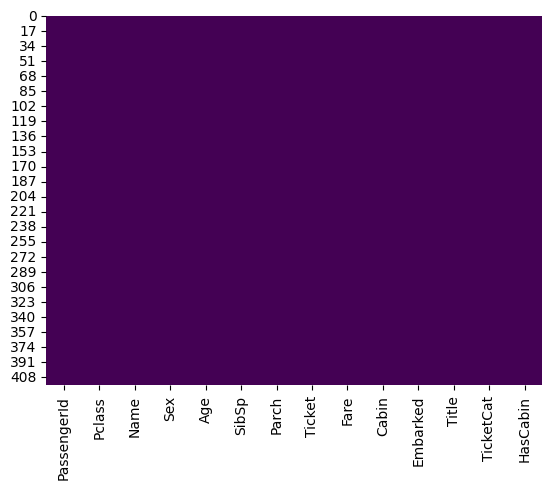

In [23]:
sns.heatmap(test.isnull(), cbar=None, cmap='viridis')

**Train-test split, one hot encoding and model fit**

In [24]:
from sklearn.model_selection import train_test_split

# Full dataset preparation
X_full = train.drop('Survived', axis=1)
y_full = train['Survived']

# Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.3, random_state=101)

# Preparing the test set
X_test = test.copy()  

# One-hot encoding separately and dropping the original columns
X_train = pd.get_dummies(X_train, columns=['Sex', 'Embarked', 'TicketCat', 'HasCabin', 'Cabin', 'Title'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['Sex', 'Embarked', 'TicketCat', 'HasCabin', 'Cabin', 'Title'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['Sex', 'Embarked', 'TicketCat', 'HasCabin','Cabin', 'Title'], drop_first=True)

# Drop the 'Name' and 'Ticket' columns
X_train = X_train.drop(['Name', 'Ticket'], axis=1)
X_val = X_val.drop(['Name', 'Ticket'], axis=1)
X_test = X_test.drop(['Name', 'Ticket'], axis=1)

# Ensuring same columns in train, validation and test after one-hot encoding
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Replacing NaN values with 0 after aligning the dataframes
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Now, your X_train and y_train should have the same number of rows
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression(max_iter=50000)
logmodel.fit(X_train, y_train)

from sklearn.metrics import classification_report

predictions_val = logmodel.predict(X_val)
print(classification_report(y_val, predictions_val))


              precision    recall  f1-score   support

           0       0.84      0.93      0.89       163
           1       0.87      0.73      0.80       104

    accuracy                           0.85       267
   macro avg       0.86      0.83      0.84       267
weighted avg       0.86      0.85      0.85       267



In [25]:
final_predictions = logmodel.predict(X_test)


In [26]:
submission_df = pd.DataFrame({'PassengerId': X_test['PassengerId'], 'Survived': final_predictions})

submission_df.to_csv('submission.csv', index=False)